In [45]:
from os import listdir
from os.path import join

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 4, 1) # input, output, kernel_size, stride
        self.conv2 = nn.Conv2d(20, 50, 4, 1)
        self.fc1 = nn.Linear(9*9*50, 500)
        self.fc2 = nn.Linear(500, 82)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 9*9*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [48]:
data_path = '../data/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

using cuda


In [49]:
model = Net()
# model = torch.load('../model/bestModel.pth', map_location=device)
model.load_state_dict(torch.load('../model/test.pth', map_location=device))
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=4050, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=82, bias=True)
)

In [50]:
trans = transforms.Compose([
    transforms.Resize((45,45)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])
trainset = torchvision.datasets.ImageFolder(root = data_path + 'extracted_images',
                                            transform = trans)
classes = trainset.classes

print(trainset.classes)
print(len(trainset.targets))


['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']
375974


In [51]:
from PIL import Image

def image_loader(image_path):
    """load image, returns cuda tensor"""
    file_list = sorted(listdir(image_path))
    imgs = []
    
    for img in file_list:
        print(img)
        image = Image.open(image_path+img)
        image = trans(image).float()
        # image = Variable(image, requires_grad=True)
        image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        imgs.append(image.cuda())
        
    return imgs  #assumes that you're using GPU

0.jpg
1.jpg
2.jpg
3.jpg
4.jpg


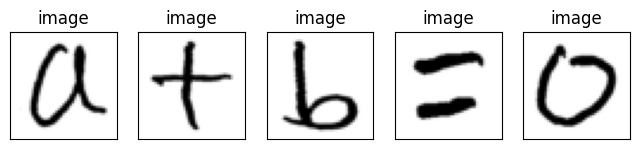

In [52]:
im_path = "../data/output/"

imgs = image_loader(im_path)
image_checks = []
for img in imgs:
    image_check = torch.squeeze(img[0])
    image_check = image_check.cpu().numpy()
    image_checks.append(image_check)
plt_imshow(img=image_checks)

In [53]:
for img in imgs:
    pred = model(img)
    probs = torch.nn.functional.softmax(pred, dim=1)
    conf, classes = torch.max(probs, 1)

    # print(conf.item())
    # print(classes.item())

    print(f'predict: {trainset.classes[classes.item()]}')

predict: A
predict: +
predict: b
predict: =
predict: theta


$ a + b = 0 $